In [1]:
############################ Create a catalogue of images ############################
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
from collections import defaultdict
from itertools import compress
import time

# Start time stamp
t = time.time()

# Get the list of image names in the folder
image_folder =  os.path.join(os.getcwd(), "Images")
list_all = os.listdir(image_folder)
is_file = [os.path.isfile(os.path.join(image_folder, list_name)) for list_name in list_all]
file_list = list(compress(list_all, is_file))

# Parse and create catalogue
max_list_length = 0;
file_name_parsed = []
image_catalogue = {}
for file_name in file_list:
    file_name = file_name[:-4]
    file_name_parsed_old = file_name_parsed
    file_name_parsed = file_name.split('_')
    if file_name_parsed[0] not in image_catalogue.keys():
        image_catalogue[file_name_parsed[0]] = {'mix_low': [], 'mix_high': []}
        if len(image_catalogue.keys()) > 1:
            max_list_length = max(max_list_length, len(image_catalogue[file_name_parsed_old[0]]['mix_low']), 
                                  len(image_catalogue[file_name_parsed_old[0]]['mix_high']))        
    else:    
        if file_name_parsed[1] == 'range(8, 18)':
            current_list = image_catalogue[file_name_parsed[0]]['mix_low']
            if  len(current_list)==0:
                current_list = [file_name_parsed[2]]
            else:
                current_list.append(file_name_parsed[2])
            image_catalogue[file_name_parsed[0]]['mix_low'] = current_list
        elif file_name_parsed[1] == 'range(2, 4)':
            current_list = image_catalogue[file_name_parsed[0]]['mix_high']
            if  len(current_list)==0:
                current_list = [file_name_parsed[2]]
            else:
                current_list.append(file_name_parsed[2])
            image_catalogue[file_name_parsed[0]]['mix_high'] = current_list

# End time stamp
elapsed = time.time() - t
print(elapsed)      


0.05783677101135254


In [3]:
####################### Load, preprocess and compute embedding of the images #######################
from PIL import Image
t = time.time()

# List of original seeds
seed_original = image_catalogue.keys()

# Numpy arrays of images
image_reduce_size = 128
image_raw = np.empty((len(seed_original)*2*max_list_length, image_reduce_size*image_reduce_size*3))
image_raw.fill(np.nan)

# Read in images and downsample
index_seed = 0;
for original_seed, mix_seed_both in image_catalogue.items():
    # Original image
    file_path = os.path.join(image_folder, ''.join([original_seed, "_original.png"]))
    image_load = Image.open(file_path)
    image_reduce = image_load.resize((image_reduce_size, image_reduce_size), resample=Image.BILINEAR)
    image_raw[index_seed, :] = np.array(image_reduce).flatten()
    index_seed = index_seed + 1
    for mix_type, mix_seed_list in mix_seed_both.items():
        for index_list, mix_seed in enumerate(mix_seed_list):
            # Mix image
            if mix_type == 'mix_low':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(8, 18)_", mix_seed, ".png"]))
            elif mix_type == 'mix_high':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(2, 4)_", mix_seed, ".png"]))
            image_load = Image.open(file_path)
            image_reduce = image_load.resize((image_reduce_size, image_reduce_size), resample=Image.BILINEAR)
            image_raw[index_seed, :] = np.array(image_reduce).flatten()
            index_seed = index_seed + 1
                
    


23.39528799057007


Text(0, 0.5, 'Fraction cumulative variance explained')

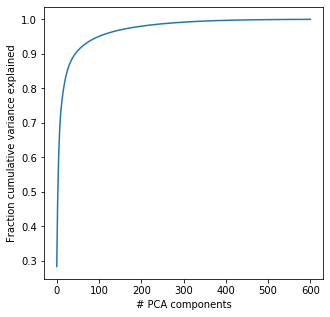

In [7]:
############################ Try PCA and plot cumulative variance as a function of num components ############################
from sklearn.decomposition import PCA

# Delete NaN rows
index_delete = np.where(np.isnan(image_raw[:, 0]))
image_raw = np.delete(image_raw, obj=index_delete, axis=0)

t = time.time()

# PCA the images
pca = PCA()
X_pca = pca.fit_transform(image_raw)

elapsed = time.time() - t
print(elapsed)   

# Plot the cumulative variance explained
cum_sum = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
plt.plot(cum_sum)
ax.set_xlabel('# PCA components')
ax.set_ylabel('Fraction cumulative variance explained')

In [45]:
############################ Recover images with PCA components ############################
# Set variance explained to 0.9
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(image_raw)

# Recover the image
X_recovered = pca.inverse_transform(X_pca)

compress_ratio = X_pca.shape[-1] / X_recovered.shape[-1]
print(''.join(['Compression ratio:', str(compress_ratio)]))

Compression ratio:0.00567626953125


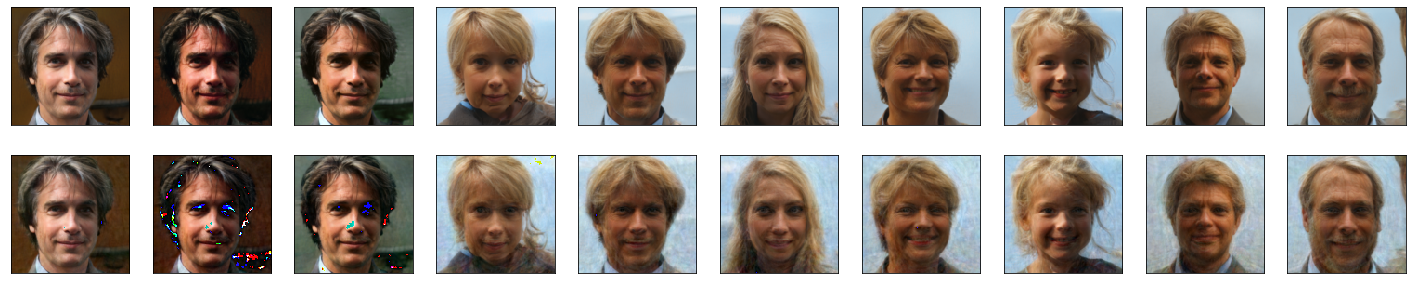

In [50]:
import matplotlib.pylab as plt

# Plot the original and recovered images
shift = 50
n_image_show = 10
fig = plt.figure(figsize=(25, 5))
for index in range(n_image_show):
    # Original
    ax = fig.add_subplot(2, n_image_show, index+1)
    plt.imshow(image_raw[index+shift, :].astype('uint8').reshape((image_reduce_size, image_reduce_size, 3)))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)  
    
    # Compressed
    ax = fig.add_subplot(2, n_image_show, index+n_image_show+1)
    plt.imshow(X_recovered[index+shift, :].astype('uint8').reshape((image_reduce_size, image_reduce_size, 3)))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)   
    

In [46]:
X_pca.shape

(601, 279)